<a href="https://colab.research.google.com/github/sourcecode369/Kaggle-Notebooks/blob/master/Supervised%20Contrastive%20Learning/Contrastive_Training_Flowers_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## References:
- https://arxiv.org/pdf/2004.11362.pdf
- https://towardsdatascience.com/contrastive-loss-for-supervised-classification-224ae35692e7

## Initial setup

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [ ]:
!nvidia-smi

Sat Jun 13 08:02:43 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!wget https://raw.githubusercontent.com/wangz10/contrastive_loss/master/losses.py

--2020-06-13 08:02:46--  https://raw.githubusercontent.com/wangz10/contrastive_loss/master/losses.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5169 (5.0K) [text/plain]
Saving to: ‘losses.py’

losses.py           100%[===================>]   5.05K  --.-KB/s    in 0s      

2020-06-13 08:02:46 (51.1 MB/s) - ‘losses.py’ saved [5169/5169]



In [ ]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tqdm.notebook import tqdm
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import losses
import time

tf.random.set_seed(666)
np.random.seed(666)

tfds.disable_progress_bar()

In [ ]:
import os
os.environ['WANDB_DISABLE_CODE'] = 'True'

## Flowers dataset

In [ ]:
# Gather Flowers dataset
train_ds, validation_ds = tfds.load(
    "tf_flowers",
    split=["train[:85%]", "train[85%:]"],
    as_supervised=True
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.



Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.0. Subsequent calls will reuse this data.


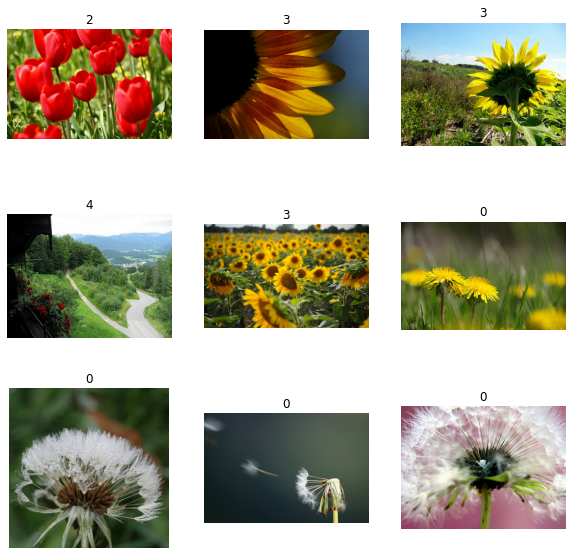

In [ ]:
# Visualization
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image)
  plt.title(int(label))
  plt.axis("off")

## Data pipeline

In [ ]:
IMG_SHAPE = 128
BS = 64
AUTO = tf.data.experimental.AUTOTUNE

# Referred from: https://arxiv.org/pdf/2002.05709.pdf (Appendxi A 
# corresponding GitHub: https://github.com/google-research/simclr/)
# I did not use all the augmentation policies proposed in the above paper

@tf.function
def custom_augment(image, label):        
    # Random flips
    image = random_apply(tf.image.flip_left_right, image, p=0.5)
    
    # Randomly apply transformation (color distortions) with probability p.
    image = random_apply(color_jitter, image, p=0.4)
    image = random_apply(color_drop, image, p=0.2)

    return (image, label)

@tf.function
def color_jitter(x, s=0.5):
    # one can also shuffle the order of following augmentations
    # each time they are applied.
    x = tf.image.random_brightness(x, max_delta=0.8*s)
    x = tf.image.random_contrast(x, lower=1-0.8*s, upper=1+0.8*s)
    x = tf.image.random_saturation(x, lower=1-0.8*s, upper=1+0.8*s)
    x = tf.image.random_hue(x, max_delta=0.2*s)
    x = tf.clip_by_value(x, 0, 1)
    return x

@tf.function
def color_drop(x):
    x = tf.image.rgb_to_grayscale(x)
    x = tf.tile(x, [1, 1, 3])
    return x

@tf.function
def random_apply(func, x, p):
    return tf.cond(
        tf.less(tf.random.uniform([], minval=0, maxval=1, dtype=tf.float32),
                tf.cast(p, tf.float32)),
        lambda: func(x),
        lambda: x)

@tf.function
def preprocess_image(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (IMG_SHAPE, IMG_SHAPE))

    return (image, label)

train_ds = (
    train_ds
    .map(preprocess_image, num_parallel_calls=AUTO)
    .shuffle(100)
    .map(custom_augment, num_parallel_calls=AUTO)
    .batch(BS)
    .prefetch(AUTO)
)

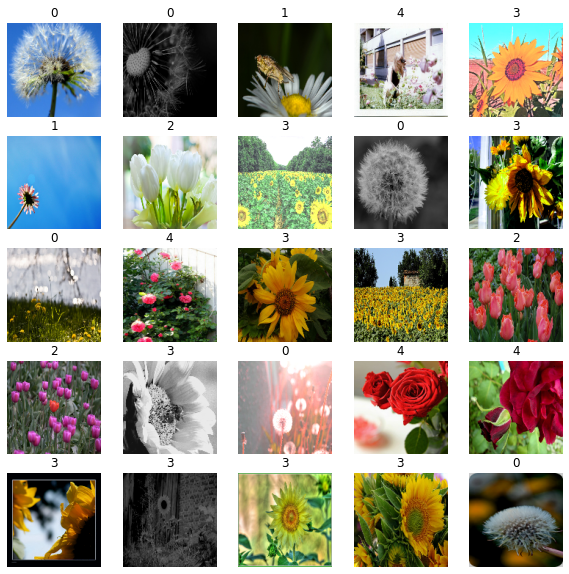

In [ ]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n+1)
    plt.imshow(image_batch[n])
    plt.title(label_batch[n].numpy())
    plt.axis('off')

## Model building

In [ ]:
# Reference: https://github.com/wangz10/contrastive_loss/blob/master/model.py
class UnitNormLayer(tf.keras.layers.Layer):
    '''Normalize vectors (euclidean norm) in batch to unit hypersphere.
    '''
    def __init__(self):
        super(UnitNormLayer, self).__init__()

    def call(self, input_tensor):
        norm = tf.norm(input_tensor, axis=1)
        return input_tensor / tf.reshape(norm, [-1, 1])

In [ ]:
# Encoder Network
def encoder_net():
	inputs = Input((IMG_SHAPE, IMG_SHAPE, 3))
	normalization_layer = UnitNormLayer()

	encoder = tf.keras.applications.ResNet50(weights=None, include_top=False)
	encoder.trainable = True

	embeddings = encoder(inputs, training=True)
	embeddings = GlobalAveragePooling2D()(embeddings)
	norm_embeddings = normalization_layer(embeddings)

	encoder_network = Model(inputs, norm_embeddings)

	return encoder_network

# Projector Network
def projector_net():
	projector = tf.keras.models.Sequential([
		Dense(128, activation="relu"),
		UnitNormLayer()
	])

	return projector

## Running forward passes through single images

In [ ]:
encoder_r = encoder_net()
projector_z = projector_net()

images, _ = next(iter(train_ds))
r = encoder_r(tf.expand_dims(images[0], 0))
z = projector_z(r)

print(tf.shape(r))
print(tf.shape(z))

tf.Tensor([   1 2048], shape=(2,), dtype=int32)
tf.Tensor([  1 128], shape=(2,), dtype=int32)


## Training the encoder and the projector

In [ ]:
decay_steps = 1000
lr_decayed_fn = tf.keras.experimental.CosineDecay(
    initial_learning_rate=0.001, decay_steps=decay_steps)
optimizer = tf.keras.optimizers.Adam(lr_decayed_fn)

In [ ]:
encoder_r = encoder_net()
projector_z = projector_net()

@tf.function
def train_step(images, labels):
	with tf.GradientTape() as tape:
		r = encoder_r(images, training=True)
		z = projector_z(r, training=True)
		loss = losses.max_margin_contrastive_loss(z, labels, metric='cosine')

	gradients = tape.gradient(loss, 
		encoder_r.trainable_variables + projector_z.trainable_variables)
	optimizer.apply_gradients(zip(gradients, 
		encoder_r.trainable_variables + projector_z.trainable_variables))

	return loss

In [ ]:
EPOCHS = 60
LOG_EVERY = 10
train_loss_results = []

start = time.time()
for epoch in tqdm(range(EPOCHS)):	
	epoch_loss_avg = tf.keras.metrics.Mean()
	
	for (images, labels) in train_ds:
		loss = train_step(images, labels)
		epoch_loss_avg.update_state(loss) 

	train_loss_results.append(epoch_loss_avg.result())
	print({"supervised_contrastive_loss": epoch_loss_avg.result()})

	if epoch % LOG_EVERY == 0:
		print("Epoch: {} Loss: {:.3f}".format(epoch, epoch_loss_avg.result()))

end = time.time()
wandb.log({"training_time": end - start})

with plt.xkcd():
    plt.plot(train_loss_results)
    plt.title("Supervised Contrastive Loss")
    plt.show()

{'supervised_contrastive_loss': <tf.Tensor: shape=(), dtype=float32, numpy=nan>}
Epoch: 0 Loss: nan
{'supervised_contrastive_loss': <tf.Tensor: shape=(), dtype=float32, numpy=nan>}
{'supervised_contrastive_loss': <tf.Tensor: shape=(), dtype=float32, numpy=nan>}
{'supervised_contrastive_loss': <tf.Tensor: shape=(), dtype=float32, numpy=nan>}
{'supervised_contrastive_loss': <tf.Tensor: shape=(), dtype=float32, numpy=nan>}
{'supervised_contrastive_loss': <tf.Tensor: shape=(), dtype=float32, numpy=nan>}
{'supervised_contrastive_loss': <tf.Tensor: shape=(), dtype=float32, numpy=nan>}
{'supervised_contrastive_loss': <tf.Tensor: shape=(), dtype=float32, numpy=nan>}
{'supervised_contrastive_loss': <tf.Tensor: shape=(), dtype=float32, numpy=nan>}
{'supervised_contrastive_loss': <tf.Tensor: shape=(), dtype=float32, numpy=nan>}
{'supervised_contrastive_loss': <tf.Tensor: shape=(), dtype=float32, numpy=nan>}
Epoch: 10 Loss: nan
{'supervised_contrastive_loss': <tf.Tensor: shape=(), dtype=float32, n

KeyboardInterrupt: ignored

## Supervised training

In [ ]:
validation_ds = (
    validation_ds
    .map(preprocess_image, num_parallel_calls=AUTO)
    .shuffle(100)
    .batch(BS)
    .prefetch(AUTO)
)

In [ ]:
def supervised_model():
	inputs = Input((IMG_SHAPE, IMG_SHAPE, 3))
	encoder_r.trainable = False

	r = encoder_r(inputs, training=False)
	outputs = Dense(5)(r)

	supervised_model = Model(inputs, outputs)

	return supervised_model

In [ ]:
supervised_classifier = supervised_model()

supervised_classifier.compile(optimizer=tf.keras.optimizers.Adam(),
	loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
	metrics=["accuracy"])

supervised_classifier.fit(train_ds,
	validation_data=validation_ds,
	epochs=50)

Epoch 1/50
49/49 [==============================] - 8s 172ms/step - loss: nan - accuracy: 0.2519 - val_loss: nan - val_accuracy: 0.2036
Epoch 2/50
49/49 [==============================] - 8s 158ms/step - loss: nan - accuracy: 0.2519 - val_loss: nan - val_accuracy: 0.2036
Epoch 3/50
49/49 [==============================] - 8s 158ms/step - loss: nan - accuracy: 0.2519 - val_loss: nan - val_accuracy: 0.2036
Epoch 4/50
49/49 [==============================] - 8s 155ms/step - loss: nan - accuracy: 0.2519 - val_loss: nan - val_accuracy: 0.2036
Epoch 5/50
49/49 [==============================] - 8s 158ms/step - loss: nan - accuracy: 0.2519 - val_loss: nan - val_accuracy: 0.2036
Epoch 6/50
49/49 [==============================] - 8s 157ms/step - loss: nan - accuracy: 0.2519 - val_loss: nan - val_accuracy: 0.2036
Epoch 7/50
49/49 [==============================] - 8s 162ms/step - loss: nan - accuracy: 0.2519 - val_loss: nan - val_accuracy: 0.2036
Epoch 8/50
49/49 [==============================

Training stabilizes a bit with augmentation but we are not getting as good results as shown [in this notebook](https://github.com/sayakpaul/Supervised-Contrastive-Learning-in-TensorFlow-2/blob/master/Contrastive_Training_Flowers.ipynb). **Note** that we are using the same augmentation policy in the training dataset like the way we did in the stage-1 of the framework. 

## SGD + Cosine Decay + `EarlyStopping`

In [ ]:
decay_steps = 1000
lr_decayed_fn = tf.keras.experimental.CosineDecay(
    initial_learning_rate=0.1, decay_steps=decay_steps)
optimizer = tf.keras.optimizers.SGD(lr_decayed_fn)

supervised_classifier = supervised_model()

supervised_classifier.compile(optimizer=optimizer,
	loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
	metrics=["accuracy"])

wandb.init(project="scl", entity="authors", id="flowers-fully-supervised-simaug-sgd")
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2,
	restore_best_weights=True, verbose=2)

supervised_classifier.fit(train_ds,
	validation_data=validation_ds,
	epochs=50,
	callbacks=[WandbCallback(), es])

Epoch 1/50
49/49 [==============================] - 12s 239ms/step - loss: 1.5500 - accuracy: 0.3657 - val_loss: 1.4792 - val_accuracy: 0.5818
Epoch 2/50
49/49 [==============================] - 11s 222ms/step - loss: 1.4503 - accuracy: 0.5429 - val_loss: 1.3736 - val_accuracy: 0.6255
Epoch 3/50
49/49 [==============================] - 11s 219ms/step - loss: 1.3738 - accuracy: 0.5712 - val_loss: 1.2878 - val_accuracy: 0.6527
Epoch 4/50
49/49 [==============================] - 11s 220ms/step - loss: 1.3137 - accuracy: 0.5782 - val_loss: 1.2196 - val_accuracy: 0.6600
Epoch 5/50
49/49 [==============================] - 11s 220ms/step - loss: 1.2667 - accuracy: 0.5856 - val_loss: 1.1659 - val_accuracy: 0.6600
Epoch 6/50
49/49 [==============================] - 11s 219ms/step - loss: 1.2306 - accuracy: 0.5869 - val_loss: 1.1238 - val_accuracy: 0.6564
Epoch 7/50
49/49 [==============================] - 11s 222ms/step - loss: 1.1999 - accuracy: 0.5856 - val_loss: 1.0893 - val_accuracy: 0.6636

## SGD + Cosine Decay + `EarlyStopping`

In [ ]:
decay_steps = 1000
lr_decayed_fn = tf.keras.experimental.CosineDecay(
    initial_learning_rate=0.1, decay_steps=decay_steps)
optimizer = tf.keras.optimizers.Adam(lr_decayed_fn)

supervised_classifier = supervised_model()

supervised_classifier.compile(optimizer=optimizer,
	loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
	metrics=["accuracy"])

es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2,
	restore_best_weights=True, verbose=2)

supervised_classifier.fit(train_ds,
	validation_data=validation_ds,
	epochs=50)

Epoch 1/50
49/49 [==============================] - 9s 179ms/step - loss: nan - accuracy: 0.2519 - val_loss: nan - val_accuracy: 0.2036
Epoch 2/50
49/49 [==============================] - 8s 160ms/step - loss: nan - accuracy: 0.2519 - val_loss: nan - val_accuracy: 0.2036
Epoch 3/50
49/49 [==============================] - 8s 160ms/step - loss: nan - accuracy: 0.2519 - val_loss: nan - val_accuracy: 0.2036
Epoch 4/50
49/49 [==============================] - 8s 162ms/step - loss: nan - accuracy: 0.2519 - val_loss: nan - val_accuracy: 0.2036
Epoch 5/50
49/49 [==============================] - 8s 165ms/step - loss: nan - accuracy: 0.2519 - val_loss: nan - val_accuracy: 0.2036
Epoch 6/50
49/49 [==============================] - 8s 161ms/step - loss: nan - accuracy: 0.2519 - val_loss: nan - val_accuracy: 0.2036
Epoch 7/50
49/49 [==============================] - 8s 159ms/step - loss: nan - accuracy: 0.2519 - val_loss: nan - val_accuracy: 0.2036
Epoch 8/50
49/49 [==============================

## Adam + Cosine Decay + **No** `EarlyStopping`

In [ ]:
decay_steps = 1000
lr_decayed_fn = tf.keras.experimental.CosineDecay(
    initial_learning_rate=0.1, decay_steps=decay_steps)
optimizer = tf.keras.optimizers.Adam(lr_decayed_fn)

supervised_classifier = supervised_model()

supervised_classifier.compile(optimizer=tf.keras.optimizers.Adam(),
	loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
	metrics=["accuracy"])

supervised_classifier.fit(train_ds,
	validation_data=validation_ds,
	epochs=100)

Epoch 1/100
49/49 [==============================] - 8s 173ms/step - loss: nan - accuracy: 0.2519 - val_loss: nan - val_accuracy: 0.2036
Epoch 2/100
49/49 [==============================] - 8s 156ms/step - loss: nan - accuracy: 0.2519 - val_loss: nan - val_accuracy: 0.2036
Epoch 3/100
49/49 [==============================] - 8s 157ms/step - loss: nan - accuracy: 0.2519 - val_loss: nan - val_accuracy: 0.2036
Epoch 4/100
49/49 [==============================] - 8s 156ms/step - loss: nan - accuracy: 0.2519 - val_loss: nan - val_accuracy: 0.2036
Epoch 5/100
49/49 [==============================] - 8s 159ms/step - loss: nan - accuracy: 0.2519 - val_loss: nan - val_accuracy: 0.2036
Epoch 6/100
49/49 [==============================] - 8s 158ms/step - loss: nan - accuracy: 0.2519 - val_loss: nan - val_accuracy: 0.2036
Epoch 7/100
49/49 [==============================] - 8s 157ms/step - loss: nan - accuracy: 0.2519 - val_loss: nan - val_accuracy: 0.2036
Epoch 8/100
49/49 [======================